# k-functions HDF5 Analysis and Testing Notebook

This notebook reads an HDF5 snapshot produced by the fkpt code, makes some plots from the snapshot, and implements alternative implementations.

## Setup and Imports

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.special import roots_legendre
from scipy.integrate import quad, simpson
from dataclasses import dataclass
from typing import Dict, Tuple
import warnings

# Configure plotting
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Configure numpy printing
np.set_printoptions(precision=6, suppress=True)

## Configuration

In [2]:
# Specify the HDF5 snapshot file to analyze
SNAPSHOT_FILE = '../kfunctions_snapshot.h5'

## Data Structures

Define classes to hold the snapshot data in an organized way.

In [3]:
@dataclass
class CosmologyParams:
    """Cosmological parameters"""
    Om: float
    h: float
    zout: float
    f0: float      # Growth rate at k→0
    Dplus: float   # Growth factor D+(z)/D+(0)

@dataclass
class ModelParams:
    """Model parameters"""
    mgmodel: str
    fR0: float

@dataclass
class KGridParams:
    """Output k-grid parameters"""
    kmin: float
    kmax: float
    Nk: int

@dataclass
class NumericalParams:
    """Numerical integration parameters"""
    nquadSteps: int

@dataclass
class KernelConstants:
    """LCDM kernel constants"""
    KA_LCDM: float
    KAp_LCDM: float
    KB_LCDM: float
    KR1_LCDM: float
    KR1p_LCDM: float

@dataclass
class SigmaValues:
    """Variance and damping integrals"""
    sigma8: float
    sigma2L: float
    sigma2v: float
    Sigma2: float
    deltaSigma2: float

@dataclass
class LinearPowerSpectrum:
    """Input linear power spectrum"""
    k: np.ndarray      # k values [h/Mpc]
    P: np.ndarray      # P(k) [(Mpc/h)³]
    Ppp: np.ndarray    # P''(k) second derivative
    f: np.ndarray      # f(k) growth rate

@dataclass
class KFunctions:
    """Output k-functions (27 arrays)"""
    k: np.ndarray
    # P22 components
    P22dd: np.ndarray
    P22du: np.ndarray
    P22uu: np.ndarray
    # P13 components
    P13dd: np.ndarray
    P13du: np.ndarray
    P13uu: np.ndarray
    # RSD A-terms
    I1udd1A: np.ndarray
    I2uud1A: np.ndarray
    I2uud2A: np.ndarray
    I3uuu2A: np.ndarray
    I3uuu3A: np.ndarray
    # RSD D-terms (B+C-G)
    I2uudd1BpC: np.ndarray
    I2uudd2BpC: np.ndarray
    I3uuud2BpC: np.ndarray
    I3uuud3BpC: np.ndarray
    I4uuuu2BpC: np.ndarray
    I4uuuu3BpC: np.ndarray
    I4uuuu4BpC: np.ndarray
    # Bias terms
    Pb1b2: np.ndarray
    Pb1bs2: np.ndarray
    Pb22: np.ndarray
    Pb2s2: np.ndarray
    Ps22: np.ndarray
    Pb2theta: np.ndarray
    Pbs2theta: np.ndarray
    # Additional
    sigma32PSL: np.ndarray
    pkl: np.ndarray    # Linear P(k) on output grid
    fk: np.ndarray     # f(k) on output grid

@dataclass
class KFunctionsSnapshot:
    """Complete snapshot data"""
    # Metadata
    timestamp: str
    command_line: str
    # Parameters
    cosmology: CosmologyParams
    model: ModelParams
    k_grid: KGridParams
    numerical: NumericalParams
    kernels: KernelConstants
    # Sigma values
    sigma_values: SigmaValues
    # Inputs
    ps_wiggle: LinearPowerSpectrum
    ps_nowiggle: LinearPowerSpectrum
    # Outputs
    kfuncs_wiggle: KFunctions
    kfuncs_nowiggle: KFunctions

## Load Snapshot

Read all data from the HDF5 file into our data structures.

In [4]:
def load_snapshot(filename: str) -> KFunctionsSnapshot:
    """Load complete k-functions snapshot from HDF5 file."""
    with h5py.File(filename, 'r') as f:
        # Metadata
        timestamp = f['/metadata'].attrs['timestamp'].decode('utf-8')
        command_line = f['/metadata'].attrs['command_line'].decode('utf-8')

        # Parameters - Cosmology
        cosmology = CosmologyParams(
            Om=f['/parameters/cosmology/Om'][0],
            h=f['/parameters/cosmology/h'][0],
            zout=f['/parameters/cosmology/zout'][0],
            f0=f['/parameters/cosmology/f0'][0],
            Dplus=f['/parameters/cosmology/Dplus'][0]
        )

        # Parameters - Model
        model = ModelParams(
            mgmodel=f['/parameters/model/mgmodel'][0].decode('utf-8'),
            fR0=f['/parameters/model/fR0'][0]
        )

        # Parameters - K-grid
        k_grid = KGridParams(
            kmin=f['/parameters/k_grid/kmin'][0],
            kmax=f['/parameters/k_grid/kmax'][0],
            Nk=f['/parameters/k_grid/Nk'][0]
        )

        # Parameters - Numerical
        numerical = NumericalParams(
            nquadSteps=f['/parameters/numerical/nquadSteps'][0]
        )

        # Parameters - Kernels
        kernels = KernelConstants(
            KA_LCDM=f['/parameters/kernels/KA_LCDM'][0],
            KAp_LCDM=f['/parameters/kernels/KAp_LCDM'][0],
            KB_LCDM=f['/parameters/kernels/KB_LCDM'][0],
            KR1_LCDM=f['/parameters/kernels/KR1_LCDM'][0],
            KR1p_LCDM=f['/parameters/kernels/KR1p_LCDM'][0]
        )

        # Sigma values
        sigma_values = SigmaValues(
            sigma8=f['/sigma_values/sigma8'][0],
            sigma2L=f['/sigma_values/sigma2L'][0],
            sigma2v=f['/sigma_values/sigma2v'][0],
            Sigma2=f['/sigma_values/Sigma2'][0],
            deltaSigma2=f['/sigma_values/deltaSigma2'][0]
        )

        # Input power spectra
        ps_wiggle_data = f['/inputs/linear_ps_wiggle'][:]
        ps_wiggle = LinearPowerSpectrum(
            k=ps_wiggle_data[:, 0],
            P=ps_wiggle_data[:, 1],
            Ppp=ps_wiggle_data[:, 2],
            f=ps_wiggle_data[:, 3]
        )

        ps_nowiggle_data = f['/inputs/linear_ps_nowiggle'][:]
        ps_nowiggle = LinearPowerSpectrum(
            k=ps_nowiggle_data[:, 0],
            P=ps_nowiggle_data[:, 1],
            Ppp=ps_nowiggle_data[:, 2],
            f=ps_nowiggle_data[:, 3]
        )

        # Helper to load k-functions
        def load_kfunctions(group_path: str) -> KFunctions:
            g = f[group_path]
            return KFunctions(
                k=g['k'][:],
                P22dd=g['P22dd'][:], P22du=g['P22du'][:], P22uu=g['P22uu'][:],
                P13dd=g['P13dd'][:], P13du=g['P13du'][:], P13uu=g['P13uu'][:],
                I1udd1A=g['I1udd1A'][:], I2uud1A=g['I2uud1A'][:], I2uud2A=g['I2uud2A'][:],
                I3uuu2A=g['I3uuu2A'][:], I3uuu3A=g['I3uuu3A'][:],
                I2uudd1BpC=g['I2uudd1BpC'][:], I2uudd2BpC=g['I2uudd2BpC'][:],
                I3uuud2BpC=g['I3uuud2BpC'][:], I3uuud3BpC=g['I3uuud3BpC'][:],
                I4uuuu2BpC=g['I4uuuu2BpC'][:], I4uuuu3BpC=g['I4uuuu3BpC'][:],
                I4uuuu4BpC=g['I4uuuu4BpC'][:],
                Pb1b2=g['Pb1b2'][:], Pb1bs2=g['Pb1bs2'][:], Pb22=g['Pb22'][:],
                Pb2s2=g['Pb2s2'][:], Ps22=g['Ps22'][:],
                Pb2theta=g['Pb2theta'][:], Pbs2theta=g['Pbs2theta'][:],
                sigma32PSL=g['sigma32PSL'][:],
                pkl=g['pkl'][:], fk=g['fk'][:]
            )

        kfuncs_wiggle = load_kfunctions('/outputs/kfunctions_wiggle')
        kfuncs_nowiggle = load_kfunctions('/outputs/kfunctions_nowiggle')

    return KFunctionsSnapshot(
        timestamp=timestamp,
        command_line=command_line,
        cosmology=cosmology,
        model=model,
        k_grid=k_grid,
        numerical=numerical,
        kernels=kernels,
        sigma_values=sigma_values,
        ps_wiggle=ps_wiggle,
        ps_nowiggle=ps_nowiggle,
        kfuncs_wiggle=kfuncs_wiggle,
        kfuncs_nowiggle=kfuncs_nowiggle
    )

# Load the snapshot
print(f"Loading snapshot from: {SNAPSHOT_FILE}")
snapshot = load_snapshot(SNAPSHOT_FILE)
print("Snapshot loaded successfully!")

Loading snapshot from: ../kfunctions_snapshot.h5
Snapshot loaded successfully!


## Inspect Metadata and Parameters

In [5]:
print("=" * 80)
print("METADATA")
print("=" * 80)
print(f"Timestamp:    {snapshot.timestamp}")
print(f"Command line: {snapshot.command_line}")
print()

print("=" * 80)
print("COSMOLOGY PARAMETERS")
print("=" * 80)
print(f"Om (Ωₘ):     {snapshot.cosmology.Om:.6f}")
print(f"h:           {snapshot.cosmology.h:.6f}")
print(f"z_out:       {snapshot.cosmology.zout:.6f}")
print(f"f₀:          {snapshot.cosmology.f0:.6f}")
print(f"D₊:          {snapshot.cosmology.Dplus:.6f}")
print()

print("=" * 80)
print("MODEL PARAMETERS")
print("=" * 80)
print(f"Model:       {snapshot.model.mgmodel}")
print(f"fR0:         {snapshot.model.fR0:.6e}")
print()

print("=" * 80)
print("K-GRID PARAMETERS")
print("=" * 80)
print(f"k_min:       {snapshot.k_grid.kmin:.6f} h/Mpc")
print(f"k_max:       {snapshot.k_grid.kmax:.6f} h/Mpc")
print(f"N_k:         {snapshot.k_grid.Nk}")
print()

print("=" * 80)
print("NUMERICAL PARAMETERS")
print("=" * 80)
print(f"nquadSteps:  {snapshot.numerical.nquadSteps}")
print()

print("=" * 80)
print("KERNEL CONSTANTS")
print("=" * 80)
print(f"KA_LCDM:     {snapshot.kernels.KA_LCDM:.10f}")
print(f"KAp_LCDM:    {snapshot.kernels.KAp_LCDM:.10f}")
print(f"KB_LCDM:     {snapshot.kernels.KB_LCDM:.10f}")
print(f"KR1_LCDM:    {snapshot.kernels.KR1_LCDM:.10f}")
print(f"KR1p_LCDM:   {snapshot.kernels.KR1p_LCDM:.10f}")
print()

print("=" * 80)
print("SIGMA VALUES")
print("=" * 80)
print(f"σ₈:          {snapshot.sigma_values.sigma8:.6f}")
print(f"σ²_L:        {snapshot.sigma_values.sigma2L:.6f} (Mpc/h)²")
print(f"σ²_v:        {snapshot.sigma_values.sigma2v:.6f} (Mpc/h)²")
print(f"Σ²:          {snapshot.sigma_values.Sigma2:.6f} (Mpc/h)²")
print(f"δΣ²:         {snapshot.sigma_values.deltaSigma2:.6f} (Mpc/h)²")
print()

print("=" * 80)
print("INPUT POWER SPECTRA")
print("=" * 80)
print(f"Wiggle PS:    {len(snapshot.ps_wiggle.k)} points")
print(f"  k range:    [{snapshot.ps_wiggle.k[0]:.6f}, {snapshot.ps_wiggle.k[-1]:.6f}] h/Mpc")
print(f"No-wiggle PS: {len(snapshot.ps_nowiggle.k)} points")
print(f"  k range:    [{snapshot.ps_nowiggle.k[0]:.6f}, {snapshot.ps_nowiggle.k[-1]:.6f}] h/Mpc")

METADATA
Timestamp:    2025-10-12 18:15:23
Command line: Om=0.3000 h=0.7000 model=HS fR0=1.000e-06 zout=0.50 fnamePS=pkl_z05.dat

COSMOLOGY PARAMETERS
Om (Ωₘ):     0.300000
h:           0.700000
z_out:       0.500000
f₀:          0.749238
D₊:          0.773172

MODEL PARAMETERS
Model:        Er
fR0:         1.000000e-06

K-GRID PARAMETERS
k_min:       0.001000 h/Mpc
k_max:       0.500000 h/Mpc
N_k:         120

NUMERICAL PARAMETERS
nquadSteps:  300

KERNEL CONSTANTS
KA_LCDM:     1.0036739877
KAp_LCDM:    0.0087880724
KB_LCDM:     1.0036739877
KR1_LCDM:    1.0069624381
KR1p_LCDM:   1.0163159950

SIGMA VALUES
σ₈:          0.643905
σ²_L:        22.514021 (Mpc/h)²
σ²_v:        23.309611 (Mpc/h)²
Σ²:          20.912087 (Mpc/h)²
δΣ²:         5.302516 (Mpc/h)²

INPUT POWER SPECTRA
Wiggle PS:    800 points
  k range:    [0.000010, 402.454556] h/Mpc
No-wiggle PS: 800 points
  k range:    [0.000010, 402.454556] h/Mpc


## Visualize Input Power Spectra

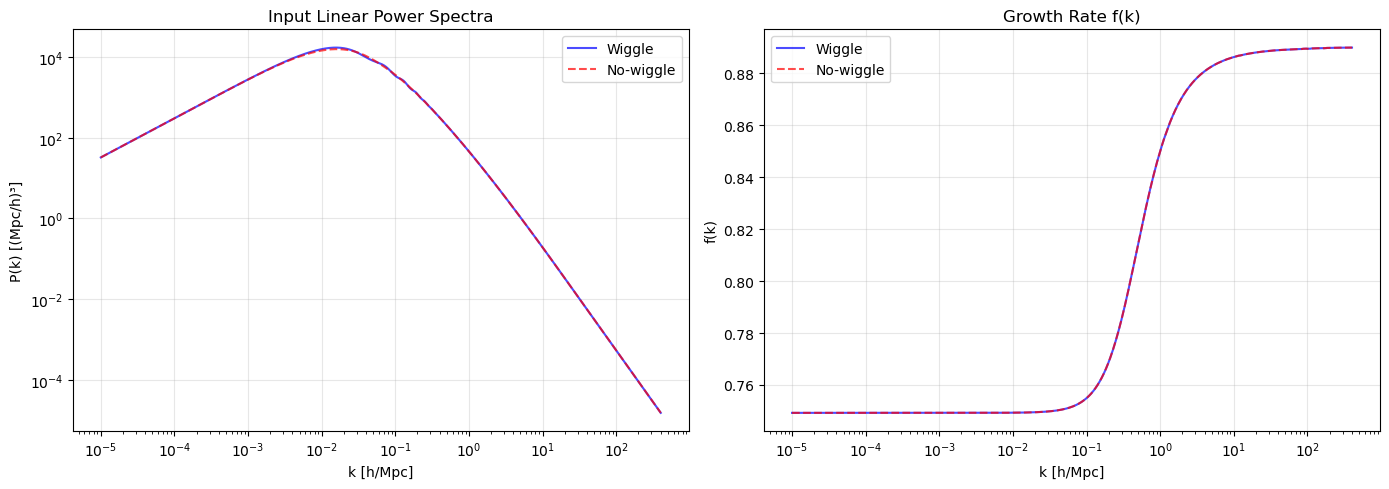

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear power spectra
ax = axes[0]
ax.loglog(snapshot.ps_wiggle.k, snapshot.ps_wiggle.P, 'b-', label='Wiggle', alpha=0.7)
ax.loglog(snapshot.ps_nowiggle.k, snapshot.ps_nowiggle.P, 'r--', label='No-wiggle', alpha=0.7)
ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel('P(k) [(Mpc/h)³]')
ax.set_title('Input Linear Power Spectra')
ax.legend()
ax.grid(True, alpha=0.3)

# Growth rate f(k)
ax = axes[1]
ax.semilogx(snapshot.ps_wiggle.k, snapshot.ps_wiggle.f, 'b-', label='Wiggle', alpha=0.7)
ax.semilogx(snapshot.ps_nowiggle.k, snapshot.ps_nowiggle.f, 'r--', label='No-wiggle', alpha=0.7)
ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel('f(k)')
ax.set_title('Growth Rate f(k)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualize Reference k-functions

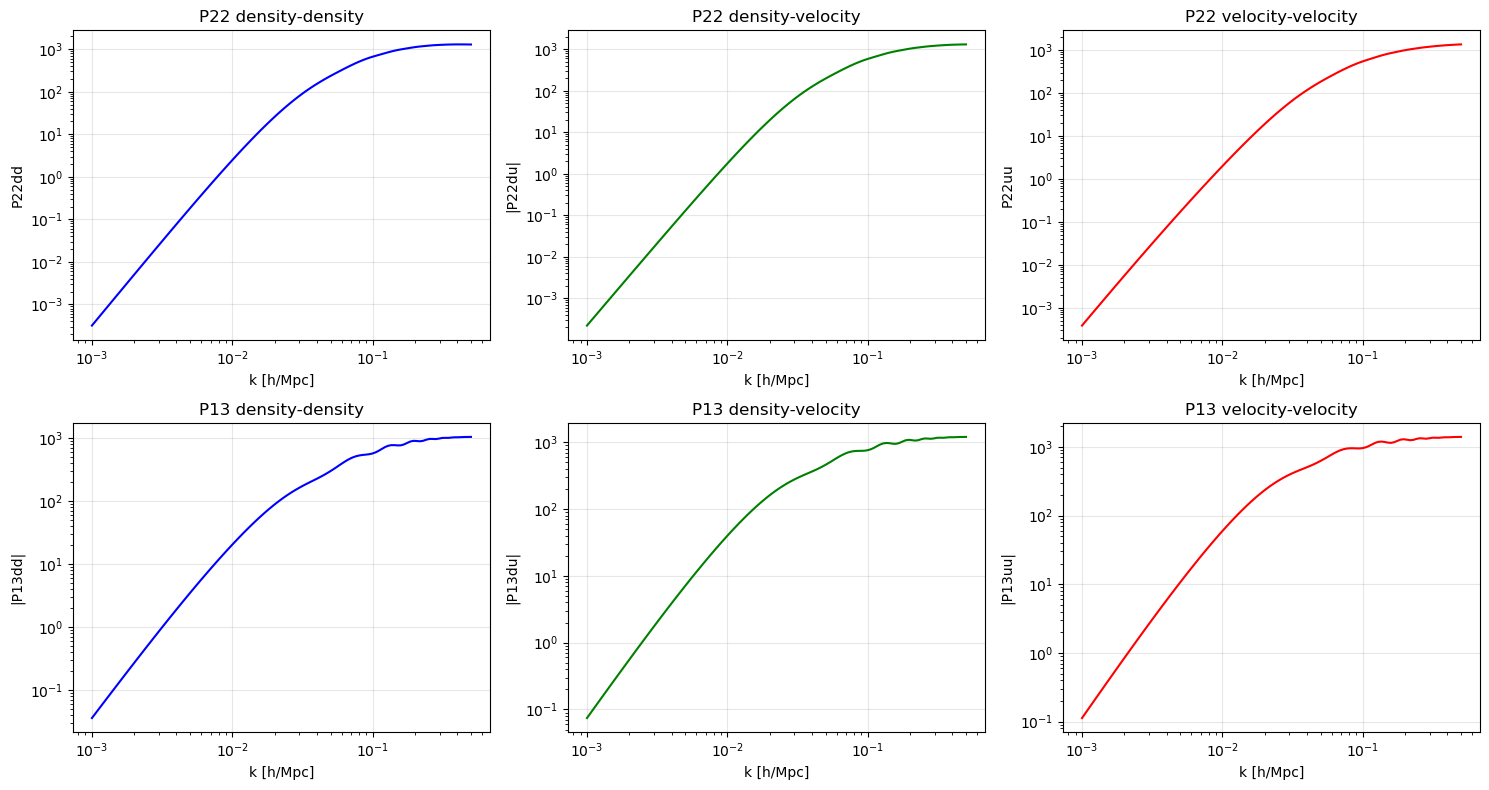

In [7]:
# Plot reference P22 and P13
ref = snapshot.kfuncs_wiggle

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# P22 components
axes[0,0].loglog(ref.k, ref.P22dd, 'b-')
axes[0,0].set_xlabel('k [h/Mpc]')
axes[0,0].set_ylabel('P22dd')
axes[0,0].set_title('P22 density-density')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].loglog(ref.k, np.abs(ref.P22du), 'g-')
axes[0,1].set_xlabel('k [h/Mpc]')
axes[0,1].set_ylabel('|P22du|')
axes[0,1].set_title('P22 density-velocity')
axes[0,1].grid(True, alpha=0.3)

axes[0,2].loglog(ref.k, ref.P22uu, 'r-')
axes[0,2].set_xlabel('k [h/Mpc]')
axes[0,2].set_ylabel('P22uu')
axes[0,2].set_title('P22 velocity-velocity')
axes[0,2].grid(True, alpha=0.3)

# P13 components
axes[1,0].loglog(ref.k, np.abs(ref.P13dd), 'b-')
axes[1,0].set_xlabel('k [h/Mpc]')
axes[1,0].set_ylabel('|P13dd|')
axes[1,0].set_title('P13 density-density')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].loglog(ref.k, np.abs(ref.P13du), 'g-')
axes[1,1].set_xlabel('k [h/Mpc]')
axes[1,1].set_ylabel('|P13du|')
axes[1,1].set_title('P13 density-velocity')
axes[1,1].grid(True, alpha=0.3)

axes[1,2].loglog(ref.k, np.abs(ref.P13uu), 'r-')
axes[1,2].set_xlabel('k [h/Mpc]')
axes[1,2].set_ylabel('|P13uu|')
axes[1,2].set_title('P13 velocity-velocity')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualize RSD Integrals

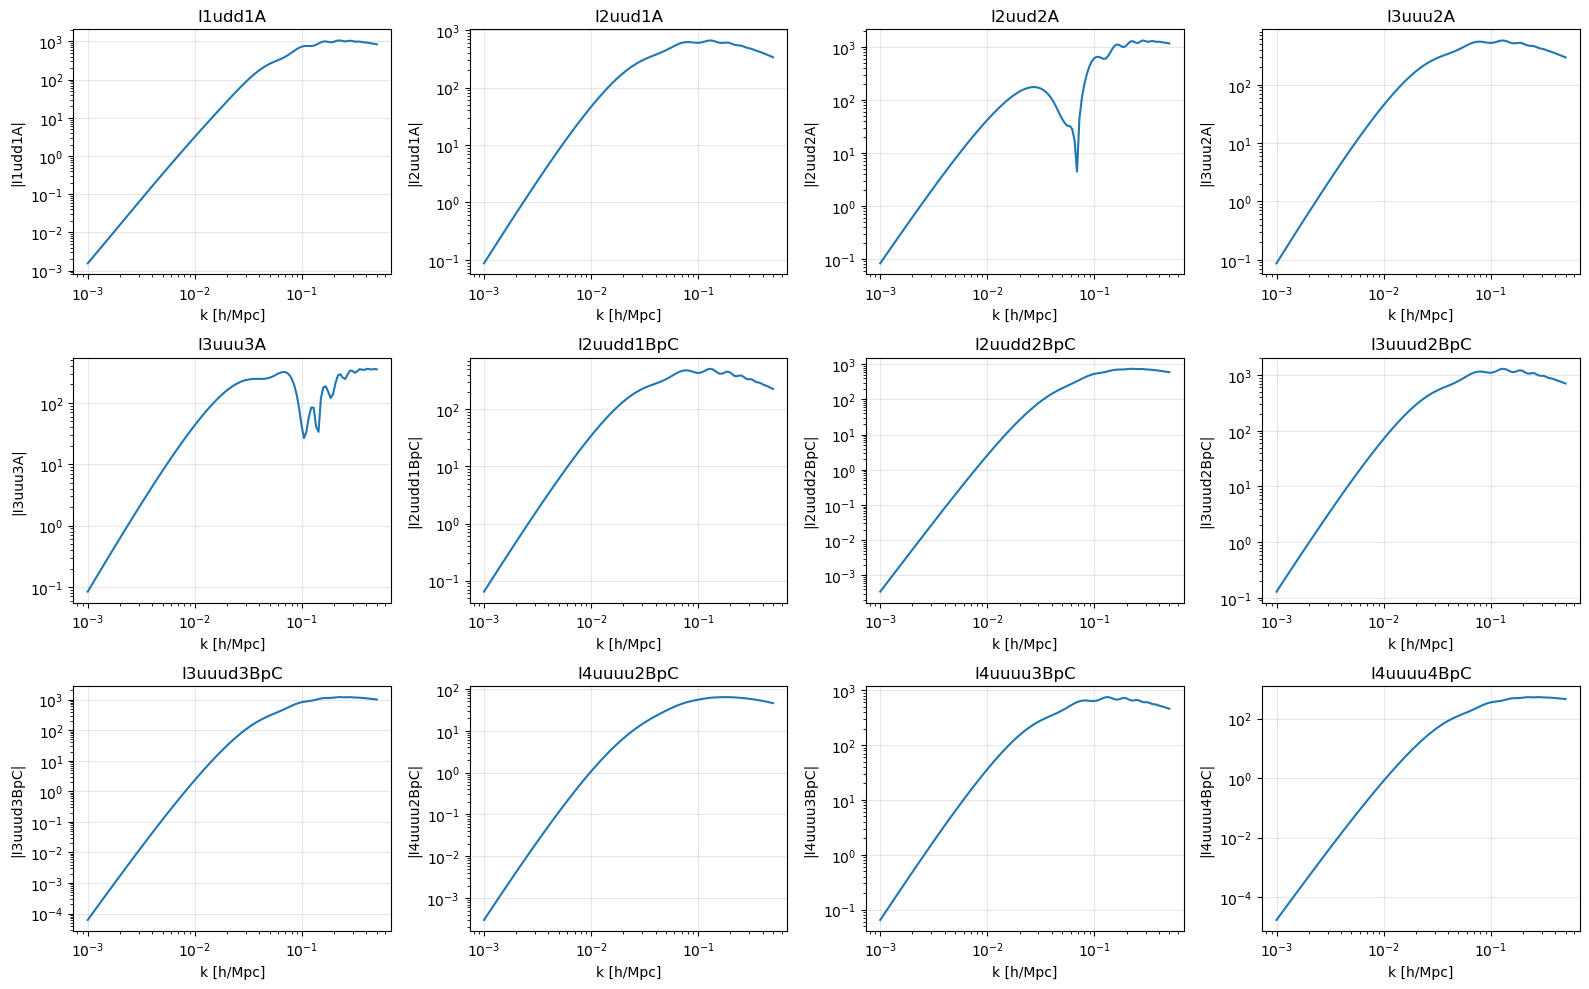

In [8]:
# Plot RSD A-terms and D-terms
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

# A-terms
a_terms = ['I1udd1A', 'I2uud1A', 'I2uud2A', 'I3uuu2A', 'I3uuu3A']
for i, name in enumerate(a_terms):
    data = getattr(ref, name)
    axes[i].loglog(ref.k, np.abs(data))
    axes[i].set_xlabel('k [h/Mpc]')
    axes[i].set_ylabel(f'|{name}|')
    axes[i].set_title(name)
    axes[i].grid(True, alpha=0.3)

# D-terms
d_terms = ['I2uudd1BpC', 'I2uudd2BpC', 'I3uuud2BpC', 'I3uuud3BpC',
           'I4uuuu2BpC', 'I4uuuu3BpC', 'I4uuuu4BpC']
for i, name in enumerate(d_terms):
    data = getattr(ref, name)
    axes[i+5].loglog(ref.k, np.abs(data))
    axes[i+5].set_xlabel('k [h/Mpc]')
    axes[i+5].set_ylabel(f'|{name}|')
    axes[i+5].set_title(name)
    axes[i+5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Python + Numpy Implementation

This first version only calculates the 3 P22 k-functions for the wiggles power spectrum, which dominate the running time. The functions below progressively vectorize the loops of the original C code:
 - calculate1: loop over k, r, mu as in the original code 1.94s
 - calculate2: loop over k, r 1.01 (2x speedup)
 - calculate3: loop over k 19.7ms (20x speedup)
 - calculate3t: loop over k with (r,mu) axes transposed 22.7ms
 - calculate4: fully vectorized (no loops) 18.2ms 
---

 **Update:**
 Includes the 3 P22 k-functions for the wiggles power spectrum + 5 3-pt correlations (I1udd1tA, I2uud1tA, I2uud2tA, I3uuu2tA, I3uuu3tA). Currently, I3uuu3A & I2uud2A do not pass the `np.allclose` assertion statements with the default tolerances `(atol=1e-5, atol=1e-8)`. 
 
 Have investigated:
 - CubicSpline (scipy) vs. Splint (C-code) interpolators being different
 - Gauss Legendre implementations being different
 - 0 vs. 1 indexing 
 - Extra precision needed
 None of the above investigations succeeded in finding the differences between Python & C results.

Added the 5 3-pt correlations to calculate1/2/3 and currently working on calculate4 update:
- calculate1: 6.45s
- calculate2: 5.7s (1.12x speedup)
- calculate3: 75ms (~75x speedup)
- calculate4: IN PROGRESS

In [32]:
def calculate1(snapshot: KFunctionsSnapshot, Nx:int=10):
    """
    Direct Python port of C code with 3 nested loops.
    Calculates P22 (2-point) AND the 5 3-point correlation functions.

    This matches the C code structure exactly:
    - Loop over k (output grid)
    - Loop over r (quadrature grid)
    - Loop over mu (Gauss-Legendre points)
    """

    # Setup logarithmic output k grid
    kmin, kmax, Nk = snapshot.k_grid.kmin, snapshot.k_grid.kmax, snapshot.k_grid.Nk
    logk_grid = np.geomspace(kmin, kmax, Nk)
    assert np.allclose(logk_grid, snapshot.kfuncs_wiggle.k), "k grids do not match!"

    # Initialize cubic spline interpolator
    k_in = snapshot.ps_wiggle.k
    Pk_in = snapshot.ps_wiggle.P
    fk_in = snapshot.ps_wiggle.f
    Pk_nw_in = snapshot.ps_nowiggle.P
    interpolator = CubicSpline(k_in, np.vstack([Pk_in, Pk_nw_in, fk_in]).T, axis=0)

    # Set up quadrature k grid
    nquadSteps = snapshot.numerical.nquadSteps
    kkmin = snapshot.ps_wiggle.k[0]
    kkmax = snapshot.ps_wiggle.k[-1]
    pmin = max(kkmin, 0.01 * kmin)
    pmax = min(kkmax, 16.0 * kmax)
    kk_grid = np.geomspace(pmin, pmax, nquadSteps)
    dkk = np.diff(kk_grid)

    # Precompute f(k) on output k grid (used on line 602)
    _, _, fout = interpolator(logk_grid).T
    fout /= snapshot.cosmology.f0  # Normalize f(k) by f0

    # Precompute P(k) and f(k) on quadrature grid
    Pkk, Pkk_nw, fkk = interpolator(kk_grid).T
    fkk /= snapshot.cosmology.f0  # Normalize f(k) by f0

    # kernel constants
    if False: # _KERNELS_LCDMfk_ on line 287
        A = snapshot.kernels.KA_LCDM
        ApOverf0 = snapshot.kernels.KAp_LCDM / snapshot.cosmology.f0
        CFD3 = snapshot.kernels.KR1_LCDM
        CFD3p = snapshot.kernels.KR1p_LCDM
    else:
        A = 1
        ApOverf0 = 0
        CFD3 = 1
        CFD3p = 1

    # Initialize Gauss-Legendre nodes and weights on [-1,1]
    xxGL, wwGL = roots_legendre(Nx)

    # Initialize output arrays - P22 terms
    P22dd = np.zeros(Nk)
    P22du = np.zeros(Nk)
    P22uu = np.zeros(Nk)

    # Initialize output arrays - 3pt Q-functions (I_tA)
    I1udd1tA = np.zeros(Nk)
    I2uud1tA = np.zeros(Nk)
    I2uud2tA = np.zeros(Nk)
    I3uuu2tA = np.zeros(Nk)
    I3uuu3tA = np.zeros(Nk)

    # Initialize output arrays - 3pt R-functions (I_a)
    I1udd1a = np.zeros(Nk)
    I2uud1a = np.zeros(Nk)
    I2uud2a = np.zeros(Nk)
    I3uuu2a = np.zeros(Nk)
    I3uuu3a = np.zeros(Nk)

    # ========== LOOP OVER K (output grid) ==========
    for i, ki in enumerate(logk_grid):
        rmax = kkmax / ki
        rmin = kkmin / ki
        rmax2 = rmax * rmax
        rmin2 = rmin * rmin

        # Initialize accumulators for P22
        P22dd_A = 0.0
        P22du_A = 0.0
        P22uu_A = 0.0
        PSLA = 0.0

        # Initialize accumulators for 3pt Q-functions
        I1udd1tA_A = 0.0
        I2uud1tA_A = 0.0
        I2uud2tA_A = 0.0
        I3uuu2tA_A = 0.0
        I3uuu3tA_A = 0.0

        # ========== Q-FUNCTIONS: Loop over r (C code line 326) ==========
        for j, kkj in enumerate(kk_grid[1:]):
            r = kkj / ki
            r2 = r * r
            PSLB = Pkk[j+1]
            fp = fkk[j+1]

            # Compute mu limits (C code lines 334-338)
            mumin = max(-1.0, (1.0 + r2 - rmax2) / (2.0 * r))
            mumax = min(1.0, (1.0 + r2 - rmin2) / (2.0 * r))
            if r >= 0.5:
                mumax = 0.5 / r

            # Scale Gauss-Legendre nodes and weights to [mumin, mumax] (C code line 339)
            dmu = mumax - mumin
            xGL = 0.5 * (dmu * xxGL + (mumax + mumin))
            wGL = 0.5 * dmu * wwGL

            # Initialize accumulators for this r value
            P22dd_B = 0.0
            P22du_B = 0.0
            P22uu_B = 0.0
            I1udd1tA_B = 0.0
            I2uud1tA_B = 0.0
            I2uud2tA_B = 0.0
            I3uuu2tA_B = 0.0
            I3uuu3tA_B = 0.0

            # ========== Loop over mu (C code line 340) ==========
            for x, w in zip(xGL, wGL):
                x2 = x * x
                y2 = 1.0 + r2 - 2.0 * r * x
                y = np.sqrt(y2)

                # Interpolate P(k*y) and f(k*y) (C code lines 347-350)
                psl, psl_nw, fkmp = interpolator(ki * y).T
                fkmp /= snapshot.cosmology.f0

                # Compute SPT kernels F2 and G2 (C code lines 352-359)
                AngleEvQ = (x - r) / y
                F2evQ = (1./2. + 3./14. * A + (1./2. - 3./14. * A) * AngleEvQ**2 +
                         AngleEvQ / 2. * (y/r + r/y))
                G2evQ = (3./14. * A * (fp + fkmp) + 3./14. * ApOverf0 +
                         (1./2. * (fp + fkmp) - 3./14. * A * (fp + fkmp) -
                          3./14. * ApOverf0) * AngleEvQ**2 +
                         AngleEvQ / 2. * (fkmp * y/r + fp * r/y))

                # P22 kernels (C code lines 362-364)
                KP22dd = 2 * r2 * F2evQ * F2evQ
                KP22du = 2 * r2 * F2evQ * G2evQ
                KP22uu = 2 * r2 * G2evQ * G2evQ

                # 3pt Q-function kernels (C code lines 368-377)
                KI1udd1tA = 2.0 * (fp * r * x + fkmp * r2 * (1.0 - r * x) / y2) * F2evQ
                KI2uud1tA = -fp * fkmp * r2 * (1.0 - x2) / y2 * F2evQ
                KI2uud2tA = (2.0 * (fp * r * x + fkmp * r2 * (1.0 - r * x) / y2) * G2evQ +
                             fp * fkmp * (r2 * (1.0 - 3.0 * x2) + 2.0 * r * x) / y2 * F2evQ)
                KI3uuu2tA = fp * fkmp * r2 * (x2 - 1.0) / y2 * G2evQ
                KI3uuu3tA = fp * fkmp * (r2 * (1.0 - 3.0 * x2) + 2.0 * r * x) / y2 * G2evQ

                # Accumulate with Gauss-Legendre weights (C code lines 421-429)
                P22dd_B += w * KP22dd * psl
                P22du_B += w * KP22du * psl
                P22uu_B += w * KP22uu * psl
                I1udd1tA_B += w * KI1udd1tA * psl
                I2uud1tA_B += w * KI2uud1tA * psl
                I2uud2tA_B += w * KI2uud2tA * psl
                I3uuu2tA_B += w * KI3uuu2tA * psl
                I3uuu3tA_B += w * KI3uuu3tA * psl

            # Trapezoidal integration over r (C code lines 450-458)
            P22dd[i] += dkk[j] * (P22dd_A * PSLA + P22dd_B * PSLB) / 2.0
            P22du[i] += dkk[j] * (P22du_A * PSLA + P22du_B * PSLB) / 2.0
            P22uu[i] += dkk[j] * (P22uu_A * PSLA + P22uu_B * PSLB) / 2.0
            I1udd1tA[i] += dkk[j] * (I1udd1tA_A * PSLA + I1udd1tA_B * PSLB) / 2.0
            I2uud1tA[i] += dkk[j] * (I2uud1tA_A * PSLA + I2uud1tA_B * PSLB) / 2.0
            I2uud2tA[i] += dkk[j] * (I2uud2tA_A * PSLA + I2uud2tA_B * PSLB) / 2.0
            I3uuu2tA[i] += dkk[j] * (I3uuu2tA_A * PSLA + I3uuu2tA_B * PSLB) / 2.0
            I3uuu3tA[i] += dkk[j] * (I3uuu3tA_A * PSLA + I3uuu3tA_B * PSLB) / 2.0

            # Update accumulators for next iteration (C code lines 477-485)
            P22dd_A = P22dd_B
            P22du_A = P22du_B
            P22uu_A = P22uu_B
            I1udd1tA_A = I1udd1tA_B
            I2uud1tA_A = I2uud1tA_B
            I2uud2tA_A = I2uud2tA_B
            I3uuu2tA_A = I3uuu2tA_B
            I3uuu3tA_A = I3uuu3tA_B
            PSLA = PSLB

        # Apply scaling for Q-functions (C code lines 509-517)
        scale = 0.5 * (ki / np.pi) ** 2
        P22dd[i] *= scale
        P22du[i] *= scale
        P22uu[i] *= scale
        I1udd1tA[i] *= scale
        I2uud1tA[i] *= scale
        I2uud2tA[i] *= scale
        I3uuu2tA[i] *= scale
        I3uuu3tA[i] *= scale

        # ========== R-FUNCTIONS: Loop over r (C code line 550) ==========
        # Get f(k) at this ki (C code lines 548-549)
        fk = fout[i]
        ##_, _ , fk = interpolator(ki).T
        ##fk /= snapshot.cosmology.f0
        # Initialize accumulators for R-functions
        I1udd1a_A = 0.0
        I2uud1a_A = 0.0
        I2uud2a_A = 0.0
        I3uuu2a_A = 0.0
        I3uuu3a_A = 0.0

        for j, kkj in enumerate(kk_grid[1:-1]):
        # for j, kkj in enumerate(kk_grid[1:]):
            r = kkj / ki
            r2 = r * r
            psl = Pkk[j+1]
            fp = fkk[j+1]

            # Initialize accumulators for this r value
            I1udd1a_B = 0.0
            I2uud1a_B = 0.0
            I2uud2a_B = 0.0
            I3uuu2a_B = 0.0
            I3uuu3a_B = 0.0

            # Loop over mu with fixed limits [-1, 1] (C code line 545, 557)
            for x, w in zip(xxGL, wwGL):
                x2 = x * x
                y2 = 1.0 + r2 - 2.0 * r * x

                # R-function kernels (C code lines 575-581)
                AngleEvR = -x
                F2evR = (1./2. + 3./14. * A + (1./2. - 3./14. * A) * AngleEvR**2 +
                         AngleEvR / 2. * (1./r + r))
                G2evR = (3./14. * A * (fp + fk) + 3./14. * ApOverf0 +
                         ((fp + fk)/2. - 3./14. * A * (fp + fk) -
                          3./14. * ApOverf0) * AngleEvR*AngleEvR +
                         AngleEvR / 2. * (fk/r + fp * r))

                # 3pt R-function kernels (C code lines 590-600)
                KI1udd1a = 2.0 * r2 * (1.0 - r * x) / y2 * G2evR + 2.0 * fp * r * x * F2evR
                KI2uud1a = -fp * r2 * (1.0 - x2) / y2 * G2evR
                KI2uud2a = ((r2 * (1.0 - 3.0 * x2) + 2.0 * r * x) / y2 * fp +
                            fk * 2.0 * r2 * (1.0 - r * x) / y2) * G2evR + 2.0 * x * r * fp * fk * F2evR
                KI3uuu2a = fk * KI2uud1a
                KI3uuu3a = (r2 * (1.0 - 3.0 * x2) + 2.0 * r * x) / y2 * fp * fk * G2evR

                # Accumulate (C code lines 609-613)
                I1udd1a_B += w * KI1udd1a * psl
                I2uud1a_B += w * KI2uud1a * psl
                I2uud2a_B += w * KI2uud2a * psl
                I3uuu2a_B += w * KI3uuu2a * psl
                I3uuu3a_B += w * KI3uuu3a * psl

            # Trapezoidal integration (C code lines 625-629)
            I1udd1a[i] += dkk[j] * (I1udd1a_A + I1udd1a_B) / (2.0 * ki)
            I2uud1a[i] += dkk[j] * (I2uud1a_A + I2uud1a_B) / (2.0 * ki)
            I2uud2a[i] += dkk[j] * (I2uud2a_A + I2uud2a_B) / (2.0 * ki)
            I3uuu2a[i] += dkk[j] * (I3uuu2a_A + I3uuu2a_B) / (2.0 * ki)
            I3uuu3a[i] += dkk[j] * (I3uuu3a_A + I3uuu3a_B) / (2.0 * ki)

            print(f'j={j} I3uuu3a={I3uuu3a[i]}')

            # Update accumulators (C code lines 637-641)
            I1udd1a_A = I1udd1a_B
            I2uud1a_A = I2uud1a_B
            I2uud2a_A = I2uud2a_B
            I3uuu2a_A = I3uuu2a_B
            I3uuu3a_A = I3uuu3a_B

        return

        # Apply scaling for R-functions (C code lines 645-654)
        pkl_k = interpolator(ki)[0]
        scale_R = (ki**3 / (4 * np.pi**2)) * pkl_k
        I1udd1a[i] *= scale_R
        I2uud1a[i] *= scale_R
        I2uud2a[i] *= scale_R
        I3uuu2a[i] *= scale_R
        I3uuu3a[i] *= scale_R

    # Combine Q and R functions (C code lines 664-668)
    I1udd1A = I1udd1tA + 2.0 * I1udd1a
    I2uud1A = I2uud1tA + 2.0 * I2uud1a
    I2uud2A = I2uud2tA + 2.0 * I2uud2a
    I3uuu2A = I3uuu2tA + 2.0 * I3uuu2a
    I3uuu3A = I3uuu3tA + 2.0 * I3uuu3a

    # Validate P22 results
    assert np.allclose(P22dd, snapshot.kfuncs_wiggle.P22dd), "P22dd does not match!"
    assert np.allclose(P22du, snapshot.kfuncs_wiggle.P22du), "P22du does not match!"
    assert np.allclose(P22uu, snapshot.kfuncs_wiggle.P22uu), "P22uu does not match!"

    # Validate 3-pt correlations
    # For the simpler functions that already pass
    assert np.allclose(I1udd1A, snapshot.kfuncs_wiggle.I1udd1A), "I1udd1A does not match!"
    assert np.allclose(I2uud1A, snapshot.kfuncs_wiggle.I2uud1A), "I2uud1A does not match!"
    assert np.allclose(I3uuu2A, snapshot.kfuncs_wiggle.I3uuu2A), "I3uuu2A does not match!"

    # For the complex functions with accumulated errors
    assert np.allclose(I3uuu3A, snapshot.kfuncs_wiggle.I3uuu3A), "I3uuu3A does not match!"
    # assert np.allclose(I2uud2A, snapshot.kfuncs_wiggle.I2uud2A), "I2uud2A does not match!"
    assert np.allclose(I3uuu3A, snapshot.kfuncs_wiggle.I3uuu3A, rtol=4e-5, atol=1e-12), "I3uuu3A does not match!"
    assert np.allclose(I2uud2A, snapshot.kfuncs_wiggle.I2uud2A, rtol=2e-4, atol=1e-12), "I2uud2A does not match!"

    return {"P22dd": P22dd,
            "P22du": P22du,
            "P22uu": P22uu,
            "I1udd1A": I1udd1A,
            "I2uud1A": I2uud1A,
            "I2uud2A": I2uud2A,
            "I3uuu2A": I3uuu2A,
            "I3uuu3A": I3uuu3A}

vals = calculate1(snapshot=snapshot, Nx=10)

j=0 I3uuu3a=-0.005258468158819934
j=1 I3uuu3a=-0.016512798178540608
j=2 I3uuu3a=-0.02882189128740823
j=3 I3uuu3a=-0.04228458615890162
j=4 I3uuu3a=-0.05700898049137451
j=5 I3uuu3a=-0.07311329781267069
j=6 I3uuu3a=-0.09072683532112634
j=7 I3uuu3a=-0.10999100031683458
j=8 I3uuu3a=-0.1310604434768404
j=9 I3uuu3a=-0.1541042979916719
j=10 I3uuu3a=-0.17930753441397254
j=11 I3uuu3a=-0.206872441979118
j=12 I3uuu3a=-0.23702024814926764
j=13 I3uuu3a=-0.26999288921337244
j=14 I3uuu3a=-0.30605494595408933
j=15 I3uuu3a=-0.3454957596766358
j=16 I3uuu3a=-0.3886317452933963
j=17 I3uuu3a=-0.4358089196808973
j=18 I3uuu3a=-0.487405665183099
j=19 I3uuu3a=-0.5438357499378076
j=20 I3uuu3a=-0.6055516286630191
j=21 I3uuu3a=-0.6730480496695747
j=22 I3uuu3a=-0.7468659961787575
j=23 I3uuu3a=-0.8275969925322091
j=24 I3uuu3a=-0.915887808601225
j=25 I3uuu3a=-1.0124455986481273
j=26 I3uuu3a=-1.1180435140795149
j=27 I3uuu3a=-1.2335268329755793
j=28 I3uuu3a=-1.359819652997339
j=29 I3uuu3a=-1.497932198281156
j=30 I3uuu3

In [10]:
%timeit -n 3 calculate1(snapshot, Nx=10)

3.87 s ± 25.8 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [ ]:
def calculate2(snapshot: KFunctionsSnapshot, Nx:int=10):
    """
    Vectorized over mu dimension.
    Calculates P22 (2-point) AND the 5 3-point correlation functions.

    Loops:
    - Loop over k (output grid)
    - Loop over r (quadrature grid)
    - Vectorized over mu (Gauss-Legendre points)
    """

    # Setup logarithmic output k grid
    kmin, kmax, Nk = snapshot.k_grid.kmin, snapshot.k_grid.kmax, snapshot.k_grid.Nk
    logk_grid = np.geomspace(kmin, kmax, Nk)
    assert np.allclose(logk_grid, snapshot.kfuncs_wiggle.k), "k grids do not match!"

    # Initialize cubic spline interpolator
    k_in = snapshot.ps_wiggle.k
    Pk_in = snapshot.ps_wiggle.P
    fk_in = snapshot.ps_wiggle.f
    Pk_nw_in = snapshot.ps_nowiggle.P
    interpolator = CubicSpline(k_in, np.vstack([Pk_in, Pk_nw_in, fk_in]).T, axis=0)

    # Set up quadrature k grid
    nquadSteps = snapshot.numerical.nquadSteps
    kkmin = snapshot.ps_wiggle.k[0]
    kkmax = snapshot.ps_wiggle.k[-1]
    pmin = max(kkmin, 0.01 * kmin)
    pmax = min(kkmax, 16.0 * kmax)
    kk_grid = np.geomspace(pmin, pmax, nquadSteps)
    dkk = np.diff(kk_grid)

    Pkk, Pkk_nw, fkk = interpolator(kk_grid).T
    fkk /= snapshot.cosmology.f0  # Normalize f(k) by f0

    # kernel constants
    if False: # _KERNELS_LCDMfk_ on line 287
        A = snapshot.kernels.KA_LCDM
        ApOverf0 = snapshot.kernels.KAp_LCDM / snapshot.cosmology.f0
        CFD3 = snapshot.kernels.KR1_LCDM
        CFD3p = snapshot.kernels.KR1p_LCDM
    else:
        A = 1
        ApOverf0 = 0
        CFD3 = 1
        CFD3p = 1

    # Initialize Gauss-Legendre nodes and weights on [-1,1]
    xxGL, wwGL = roots_legendre(Nx)

    # Initialize output arrays - P22 terms
    P22dd = np.zeros(Nk)
    P22du = np.zeros(Nk)
    P22uu = np.zeros(Nk)

    # Initialize output arrays - 3pt Q-functions (I_tA)
    I1udd1tA = np.zeros(Nk)
    I2uud1tA = np.zeros(Nk)
    I2uud2tA = np.zeros(Nk)
    I3uuu2tA = np.zeros(Nk)
    I3uuu3tA = np.zeros(Nk)

    # Initialize output arrays - 3pt R-functions (I_a)
    I1udd1a = np.zeros(Nk)
    I2uud1a = np.zeros(Nk)
    I2uud2a = np.zeros(Nk)
    I3uuu2a = np.zeros(Nk)
    I3uuu3a = np.zeros(Nk)

    # ========== LOOP OVER K (output grid) ==========
    for i, ki in enumerate(logk_grid):
        rmax = kkmax / ki
        rmin = kkmin / ki
        rmax2 = rmax * rmax
        rmin2 = rmin * rmin

        # Initialize accumulators for P22
        P22dd_A = 0.0
        P22du_A = 0.0
        P22uu_A = 0.0
        PSLA = 0.0

        # Initialize accumulators for 3pt Q-functions
        I1udd1tA_A = 0.0
        I2uud1tA_A = 0.0
        I2uud2tA_A = 0.0
        I3uuu2tA_A = 0.0
        I3uuu3tA_A = 0.0

        # ========== Q-FUNCTIONS: Loop over r (C code line 326) ==========
        for j, kkj in enumerate(kk_grid[1:]):
            r = kkj / ki
            r2 = r * r
            PSLB = Pkk[j+1]
            fp = fkk[j+1]

            # Compute mu limits (C code lines 334-338)
            mumin = max(-1.0, (1.0 + r2 - rmax2) / (2.0 * r))
            mumax = min(1.0, (1.0 + r2 - rmin2) / (2.0 * r))
            if r >= 0.5:
                mumax = 0.5 / r

            # Scale Gauss-Legendre nodes and weights to [mumin, mumax] (C code line 339)
            dmu = mumax - mumin
            xGL = 0.5 * (dmu * xxGL + (mumax + mumin))
            wGL = 0.5 * dmu * wwGL

            # ========== VECTORIZED over mu (C code line 340) ==========
            x, w = xGL, wGL
            x2 = x * x
            y2 = 1.0 + r2 - 2.0 * r * x
            y = np.sqrt(y2)

            # Interpolate P(k*y) and f(k*y) (C code lines 347-350)
            psl, psl_nw, fkmp = interpolator(ki * y).T
            fkmp /= snapshot.cosmology.f0

            # Compute SPT kernels F2 and G2 (C code lines 352-359)
            AngleEvQ = (x - r) / y
            F2evQ = (1./2. + 3./14. * A + (1./2. - 3./14. * A) * AngleEvQ**2 +
                     AngleEvQ / 2. * (y/r + r/y))
            G2evQ = (3./14. * A * (fp + fkmp) + 3./14. * ApOverf0 +
                     (1./2. * (fp + fkmp) - 3./14. * A * (fp + fkmp) -
                      3./14. * ApOverf0) * AngleEvQ**2 +
                     AngleEvQ / 2. * (fkmp * y/r + fp * r/y))

            # P22 kernels (C code lines 362-364)
            KP22dd = 2 * r2 * F2evQ * F2evQ
            KP22du = 2 * r2 * F2evQ * G2evQ
            KP22uu = 2 * r2 * G2evQ * G2evQ

            # 3pt Q-function kernels (C code lines 368-377)
            KI1udd1tA = 2.0 * (fp * r * x + fkmp * r2 * (1.0 - r * x) / y2) * F2evQ
            KI2uud1tA = -fp * fkmp * r2 * (1.0 - x2) / y2 * F2evQ
            KI2uud2tA = (2.0 * (fp * r * x + fkmp * r2 * (1.0 - r * x) / y2) * G2evQ +
                         fp * fkmp * (r2 * (1.0 - 3.0 * x2) + 2.0 * r * x) / y2 * F2evQ)
            KI3uuu2tA = fp * fkmp * r2 * (x2 - 1.0) / y2 * G2evQ
            KI3uuu3tA = fp * fkmp * (r2 * (1.0 - 3.0 * x2) + 2.0 * r * x) / y2 * G2evQ

            # Accumulate with Gauss-Legendre weights (C code lines 421-429)
            P22dd_B = np.sum(w * KP22dd * psl)
            P22du_B = np.sum(w * KP22du * psl)
            P22uu_B = np.sum(w * KP22uu * psl)
            I1udd1tA_B = np.sum(w * KI1udd1tA * psl)
            I2uud1tA_B = np.sum(w * KI2uud1tA * psl)
            I2uud2tA_B = np.sum(w * KI2uud2tA * psl)
            I3uuu2tA_B = np.sum(w * KI3uuu2tA * psl)
            I3uuu3tA_B = np.sum(w * KI3uuu3tA * psl)

            # Trapezoidal integration over r (C code lines 450-458)
            P22dd[i] += dkk[j] * (P22dd_A * PSLA + P22dd_B * PSLB) / 2.0
            P22du[i] += dkk[j] * (P22du_A * PSLA + P22du_B * PSLB) / 2.0
            P22uu[i] += dkk[j] * (P22uu_A * PSLA + P22uu_B * PSLB) / 2.0
            I1udd1tA[i] += dkk[j] * (I1udd1tA_A * PSLA + I1udd1tA_B * PSLB) / 2.0
            I2uud1tA[i] += dkk[j] * (I2uud1tA_A * PSLA + I2uud1tA_B * PSLB) / 2.0
            I2uud2tA[i] += dkk[j] * (I2uud2tA_A * PSLA + I2uud2tA_B * PSLB) / 2.0
            I3uuu2tA[i] += dkk[j] * (I3uuu2tA_A * PSLA + I3uuu2tA_B * PSLB) / 2.0
            I3uuu3tA[i] += dkk[j] * (I3uuu3tA_A * PSLA + I3uuu3tA_B * PSLB) / 2.0

            # Update accumulators for next iteration (C code lines 477-485)
            P22dd_A = P22dd_B
            P22du_A = P22du_B
            P22uu_A = P22uu_B
            I1udd1tA_A = I1udd1tA_B
            I2uud1tA_A = I2uud1tA_B
            I2uud2tA_A = I2uud2tA_B
            I3uuu2tA_A = I3uuu2tA_B
            I3uuu3tA_A = I3uuu3tA_B
            PSLA = PSLB

        # Apply scaling for Q-functions (C code lines 509-517)
        scale = 0.5 * (ki / np.pi) ** 2
        P22dd[i] *= scale
        P22du[i] *= scale
        P22uu[i] *= scale
        I1udd1tA[i] *= scale
        I2uud1tA[i] *= scale
        I2uud2tA[i] *= scale
        I3uuu2tA[i] *= scale
        I3uuu3tA[i] *= scale

        # ========== R-FUNCTIONS: Loop over r (C code line 550) ==========
        # Get f(k) at this ki (C code lines 548-549)
        fk = interpolator(ki)[2] / snapshot.cosmology.f0
        # Initialize accumulators for R-functions
        I1udd1a_A = 0.0
        I2uud1a_A = 0.0
        I2uud2a_A = 0.0
        I3uuu2a_A = 0.0
        I3uuu3a_A = 0.0

        for j, kkj in enumerate(kk_grid[1:-1]):
            r = kkj / ki
            r2 = r * r
            psl = Pkk[j+1]
            fp = fkk[j+1]

            # ========== VECTORIZED over mu with fixed limits [-1, 1] ==========
            x, w = xxGL, wwGL
            x2 = x * x
            y2 = 1.0 + r2 - 2.0 * r * x

            # R-function kernels (C code lines 575-581)
            AngleEvR = -x
            F2evR = (1./2. + 3./14. * A + (1./2. - 3./14. * A) * AngleEvR**2 +
                     AngleEvR / 2. * (1./r + r))
            G2evR = (3./14. * A * (fp + fk) + 3./14. * ApOverf0 +
                     (1./2. * (fp + fk) - 3./14. * A * (fp + fk) -
                      3./14. * ApOverf0) * AngleEvR**2 +
                     AngleEvR / 2. * (fk/r + fp * r))

            # 3pt R-function kernels (C code lines 590-600)
            KI1udd1a = 2.0 * r2 * (1.0 - r * x) / y2 * G2evR + 2.0 * fp * r * x * F2evR
            KI2uud1a = -fp * r2 * (1.0 - x2) / y2 * G2evR
            KI2uud2a = ((r2 * (1.0 - 3.0 * x2) + 2.0 * r * x) / y2 * fp +
                        fk * 2.0 * r2 * (1.0 - r * x) / y2) * G2evR + 2.0 * x * r * fp * fk * F2evR
            KI3uuu2a = fk * KI2uud1a
            KI3uuu3a = (r2 * (1.0 - 3.0 * x2) + 2.0 * r * x) / y2 * fp * fk * G2evR

            # Accumulate (C code lines 609-613)
            I1udd1a_B = np.sum(w * KI1udd1a * psl)
            I2uud1a_B = np.sum(w * KI2uud1a * psl)
            I2uud2a_B = np.sum(w * KI2uud2a * psl)
            I3uuu2a_B = np.sum(w * KI3uuu2a * psl)
            I3uuu3a_B = np.sum(w * KI3uuu3a * psl)

            # Trapezoidal integration (C code lines 625-629)
            I1udd1a[i] += dkk[j] * (I1udd1a_A + I1udd1a_B) / (2.0 * ki)
            I2uud1a[i] += dkk[j] * (I2uud1a_A + I2uud1a_B) / (2.0 * ki)
            I2uud2a[i] += dkk[j] * (I2uud2a_A + I2uud2a_B) / (2.0 * ki)
            I3uuu2a[i] += dkk[j] * (I3uuu2a_A + I3uuu2a_B) / (2.0 * ki)
            I3uuu3a[i] += dkk[j] * (I3uuu3a_A + I3uuu3a_B) / (2.0 * ki)

            # Update accumulators (C code lines 637-641)
            I1udd1a_A = I1udd1a_B
            I2uud1a_A = I2uud1a_B
            I2uud2a_A = I2uud2a_B
            I3uuu2a_A = I3uuu2a_B
            I3uuu3a_A = I3uuu3a_B

        # Apply scaling for R-functions (C code lines 645-654)
        pkl_k = interpolator(ki)[0]
        scale_R = (ki**3 / (4 * np.pi**2)) * pkl_k
        I1udd1a[i] *= scale_R
        I2uud1a[i] *= scale_R
        I2uud2a[i] *= scale_R
        I3uuu2a[i] *= scale_R
        I3uuu3a[i] *= scale_R

    # Combine Q and R functions (C code lines 664-668)
    I1udd1A = I1udd1tA + 2.0 * I1udd1a
    I2uud1A = I2uud1tA + 2.0 * I2uud1a
    I2uud2A = I2uud2tA + 2.0 * I2uud2a
    I3uuu2A = I3uuu2tA + 2.0 * I3uuu2a
    I3uuu3A = I3uuu3tA + 2.0 * I3uuu3a

    # Validate P22 results
    assert np.allclose(P22dd, snapshot.kfuncs_wiggle.P22dd), "P22dd does not match!"
    assert np.allclose(P22du, snapshot.kfuncs_wiggle.P22du), "P22du does not match!"
    assert np.allclose(P22uu, snapshot.kfuncs_wiggle.P22uu), "P22uu does not match!"

    # Validate 3-pt correlations
    assert np.allclose(I1udd1A, snapshot.kfuncs_wiggle.I1udd1A), "I1udd1A does not match!"
    assert np.allclose(I2uud1A, snapshot.kfuncs_wiggle.I2uud1A), "I2uud1A does not match!"
    assert np.allclose(I3uuu2A, snapshot.kfuncs_wiggle.I3uuu2A), "I3uuu2A does not match!"
    assert np.allclose(I3uuu3A, snapshot.kfuncs_wiggle.I3uuu3A, rtol=4e-5, atol=1e-12), "I3uuu3A does not match!"
    assert np.allclose(I2uud2A, snapshot.kfuncs_wiggle.I2uud2A, rtol=2e-4, atol=1e-12), "I2uud2A does not match!"

    return {"P22dd": P22dd,
            "P22du": P22du,
            "P22uu": P22uu,
            "I1udd1A": I1udd1A,
            "I2uud1A": I2uud1A,
            "I2uud2A": I2uud2A,
            "I3uuu2A": I3uuu2A,
            "I3uuu3A": I3uuu3A}

In [12]:
%timeit -n 3 calculate2(snapshot=snapshot, Nx=10)

3.21 s ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [ ]:
def calculate3(snapshot: KFunctionsSnapshot, Nx:int=10):
    """
    Vectorized over r and mu dimensions (like calculate3).
    Calculates P22 (2-point) AND the 5 3-point correlation functions.

    Loops:
    - Loop over k (output grid)
    - Vectorized over r (quadrature grid)
    - Vectorized over mu (Gauss-Legendre points)
    """

    # Setup logarithmic output k grid
    kmin, kmax, Nk = snapshot.k_grid.kmin, snapshot.k_grid.kmax, snapshot.k_grid.Nk
    logk_grid = np.geomspace(kmin, kmax, Nk)
    assert np.allclose(logk_grid, snapshot.kfuncs_wiggle.k), "k grids do not match!"

    # Initialize cubic spline interpolator
    k_in = snapshot.ps_wiggle.k
    Pk_in = snapshot.ps_wiggle.P
    fk_in = snapshot.ps_wiggle.f
    Pk_nw_in = snapshot.ps_nowiggle.P
    interpolator = CubicSpline(k_in, np.vstack([Pk_in, Pk_nw_in, fk_in]).T, axis=0)

    # Set up quadrature k grid
    nquadSteps = snapshot.numerical.nquadSteps
    kkmin = snapshot.ps_wiggle.k[0]
    kkmax = snapshot.ps_wiggle.k[-1]
    pmin = max(kkmin, 0.01 * kmin)
    pmax = min(kkmax, 16.0 * kmax)
    kk_grid = np.geomspace(pmin, pmax, nquadSteps)
    dkk = np.diff(kk_grid)

    Pkk, Pkk_nw, fkk = interpolator(kk_grid).T
    fkk /= snapshot.cosmology.f0  # Normalize f(k) by f0

    # kernel constants
    if False: # _KERNELS_LCDMfk_ on line 287
        A = snapshot.kernels.KA_LCDM
        ApOverf0 = snapshot.kernels.KAp_LCDM / snapshot.cosmology.f0
        CFD3 = snapshot.kernels.KR1_LCDM
        CFD3p = snapshot.kernels.KR1p_LCDM
    else:
        A = 1
        ApOverf0 = 0
        CFD3 = 1
        CFD3p = 1

    # Initialize Gauss-Legendre nodes and weights on [-1,1]
    xxGL, wwGL = roots_legendre(Nx)

    # Initialize output arrays - P22 terms
    P22dd = np.zeros(Nk)
    P22du = np.zeros(Nk)
    P22uu = np.zeros(Nk)

    # Initialize output arrays - 3pt Q-functions (I_tA)
    I1udd1tA = np.zeros(Nk)
    I2uud1tA = np.zeros(Nk)
    I2uud2tA = np.zeros(Nk)
    I3uuu2tA = np.zeros(Nk)
    I3uuu3tA = np.zeros(Nk)

    # Initialize output arrays - 3pt R-functions (I_a)
    I1udd1a = np.zeros(Nk)
    I2uud1a = np.zeros(Nk)
    I2uud2a = np.zeros(Nk)
    I3uuu2a = np.zeros(Nk)
    I3uuu3a = np.zeros(Nk)

    # ========== LOOP OVER K (output grid) ==========
    for i, ki in enumerate(logk_grid):
        rmax = kkmax / ki
        rmin = kkmin / ki
        rmax2 = rmax * rmax
        rmin2 = rmin * rmin

        # Initialize accumulator arrays for this k value
        P22dd_B = np.zeros(nquadSteps)
        P22du_B = np.zeros(nquadSteps)
        P22uu_B = np.zeros(nquadSteps)
        I1udd1tA_B = np.zeros(nquadSteps)
        I2uud1tA_B = np.zeros(nquadSteps)
        I2uud2tA_B = np.zeros(nquadSteps)
        I3uuu2tA_B = np.zeros(nquadSteps)
        I3uuu3tA_B = np.zeros(nquadSteps)

        # ========== Q-FUNCTIONS: Vectorized over r ==========
        fp = fkk[1:]
        r = kk_grid[1:] / ki
        r2 = r * r
        mumin = np.maximum(-1, (1 + r2 - rmax2) / (2 * r))
        mumax = np.minimum(1, (1 + r2 - rmin2) / (2 * r))
        mumax = np.divide(0.5, r, out=mumax, where=r >= 0.5)

        # Scale Gauss-Legendre nodes and weights to [mumin, mumax]
        # Shapes are (Nx, nquadSteps-1)
        dmu = mumax - mumin
        xGL = 0.5 * (dmu * xxGL.reshape(-1, 1) + (mumax + mumin))
        wGL = 0.5 * dmu * wwGL.reshape(-1, 1)

        # ========== VECTORIZED over mu (shape: Nx x nquadSteps-1) ==========
        x, w = xGL, wGL
        x2 = x * x
        y2 = 1 + r2 - 2 * r * x
        y = np.sqrt(y2)
        psl, psl_nw, fkmp = interpolator(ki * y).T
        fkmp /= snapshot.cosmology.f0
        psl = psl.T
        fkmp = fkmp.T

        # Compute SPT kernels F2 and G2
        AngleEvQ = (x - r) / y
        F2evQ = (1./2. + 3./14. * A + (1./2. - 3./14. * A) * AngleEvQ**2 +
                 AngleEvQ / 2. * (y/r + r/y))
        G2evQ = (3./14. * A * (fp + fkmp) + 3./14. * ApOverf0 +
                 (1./2. * (fp + fkmp) - 3./14. * A * (fp + fkmp) -
                  3./14. * ApOverf0) * AngleEvQ**2 +
                 AngleEvQ / 2. * (fkmp * y/r + fp * r/y))

        # P22 kernels
        KP22dd = 2 * r2 * F2evQ * F2evQ
        KP22du = 2 * r2 * F2evQ * G2evQ
        KP22uu = 2 * r2 * G2evQ * G2evQ

        # 3pt Q-function kernels
        KI1udd1tA = 2.0 * (fp * r * x + fkmp * r2 * (1.0 - r * x) / y2) * F2evQ
        KI2uud1tA = -fp * fkmp * r2 * (1.0 - x2) / y2 * F2evQ
        KI2uud2tA = (2.0 * (fp * r * x + fkmp * r2 * (1.0 - r * x) / y2) * G2evQ +
                     fp * fkmp * (r2 * (1.0 - 3.0 * x2) + 2.0 * r * x) / y2 * F2evQ)
        KI3uuu2tA = fp * fkmp * r2 * (x2 - 1.0) / y2 * G2evQ
        KI3uuu3tA = fp * fkmp * (r2 * (1.0 - 3.0 * x2) + 2.0 * r * x) / y2 * G2evQ

        # Accumulate with Gauss-Legendre weights (sum over mu dimension)
        P22dd_B[1:] = np.sum(w * KP22dd * psl, axis=0)
        P22du_B[1:] = np.sum(w * KP22du * psl, axis=0)
        P22uu_B[1:] = np.sum(w * KP22uu * psl, axis=0)
        I1udd1tA_B[1:] = np.sum(w * KI1udd1tA * psl, axis=0)
        I2uud1tA_B[1:] = np.sum(w * KI2uud1tA * psl, axis=0)
        I2uud2tA_B[1:] = np.sum(w * KI2uud2tA * psl, axis=0)
        I3uuu2tA_B[1:] = np.sum(w * KI3uuu2tA * psl, axis=0)
        I3uuu3tA_B[1:] = np.sum(w * KI3uuu3tA * psl, axis=0)

        # Trapezoidal integration over r (vectorized)
        P22dd[i] = np.sum(dkk * (P22dd_B[:-1]*Pkk[:-1] + P22dd_B[1:]*Pkk[1:]) / 2.0)
        P22du[i] = np.sum(dkk * (P22du_B[:-1]*Pkk[:-1] + P22du_B[1:]*Pkk[1:]) / 2.0)
        P22uu[i] = np.sum(dkk * (P22uu_B[:-1]*Pkk[:-1] + P22uu_B[1:]*Pkk[1:]) / 2.0)
        I1udd1tA[i] = np.sum(dkk * (I1udd1tA_B[:-1]*Pkk[:-1] + I1udd1tA_B[1:]*Pkk[1:]) / 2.0)
        I2uud1tA[i] = np.sum(dkk * (I2uud1tA_B[:-1]*Pkk[:-1] + I2uud1tA_B[1:]*Pkk[1:]) / 2.0)
        I2uud2tA[i] = np.sum(dkk * (I2uud2tA_B[:-1]*Pkk[:-1] + I2uud2tA_B[1:]*Pkk[1:]) / 2.0)
        I3uuu2tA[i] = np.sum(dkk * (I3uuu2tA_B[:-1]*Pkk[:-1] + I3uuu2tA_B[1:]*Pkk[1:]) / 2.0)
        I3uuu3tA[i] = np.sum(dkk * (I3uuu3tA_B[:-1]*Pkk[:-1] + I3uuu3tA_B[1:]*Pkk[1:]) / 2.0)

        # Apply scaling for Q-functions
        scale = 0.5 * (ki / np.pi) ** 2
        P22dd[i] *= scale
        P22du[i] *= scale
        P22uu[i] *= scale
        I1udd1tA[i] *= scale
        I2uud1tA[i] *= scale
        I2uud2tA[i] *= scale
        I3uuu2tA[i] *= scale
        I3uuu3tA[i] *= scale

        # ========== R-FUNCTIONS: Vectorized over r ==========
        # Get f(k) at this ki
        fk = interpolator(ki)[2] / snapshot.cosmology.f0

        # Initialize accumulator arrays for R-functions
        I1udd1a_B = np.zeros(nquadSteps)
        I2uud1a_B = np.zeros(nquadSteps)
        I2uud2a_B = np.zeros(nquadSteps)
        I3uuu2a_B = np.zeros(nquadSteps)
        I3uuu3a_B = np.zeros(nquadSteps)

        # Vectorized over r (excluding last point as in calculate1_with_3pt)
        fp = fkk[1:-1]
        r = kk_grid[1:-1] / ki
        r2 = r * r
        psl = Pkk[1:-1]

        # ========== VECTORIZED over mu with fixed limits [-1, 1] ==========
        # Shapes are (Nx, nquadSteps-2)
        x = xxGL.reshape(-1, 1)
        w = wwGL.reshape(-1, 1)
        x2 = x * x
        y2 = 1.0 + r2 - 2.0 * r * x

        # R-function kernels
        AngleEvR = -x
        F2evR = (1./2. + 3./14. * A + (1./2. - 3./14. * A) * AngleEvR**2 +
                 AngleEvR / 2. * (1./r + r))
        G2evR = (3./14. * A * (fp + fk) + 3./14. * ApOverf0 +
                 (1./2. * (fp + fk) - 3./14. * A * (fp + fk) -
                  3./14. * ApOverf0) * AngleEvR**2 +
                 AngleEvR / 2. * (fk/r + fp * r))

        # 3pt R-function kernels
        KI1udd1a = 2.0 * r2 * (1.0 - r * x) / y2 * G2evR + 2.0 * fp * r * x * F2evR
        KI2uud1a = -fp * r2 * (1.0 - x2) / y2 * G2evR
        KI2uud2a = ((r2 * (1.0 - 3.0 * x2) + 2.0 * r * x) / y2 * fp +
                    fk * 2.0 * r2 * (1.0 - r * x) / y2) * G2evR + 2.0 * x * r * fp * fk * F2evR
        KI3uuu2a = fk * KI2uud1a
        KI3uuu3a = (r2 * (1.0 - 3.0 * x2) + 2.0 * r * x) / y2 * fp * fk * G2evR

        # Accumulate (sum over mu dimension)
        I1udd1a_B[1:-1] = np.sum(w * KI1udd1a * psl, axis=0)
        I2uud1a_B[1:-1] = np.sum(w * KI2uud1a * psl, axis=0)
        I2uud2a_B[1:-1] = np.sum(w * KI2uud2a * psl, axis=0)
        I3uuu2a_B[1:-1] = np.sum(w * KI3uuu2a * psl, axis=0)
        I3uuu3a_B[1:-1] = np.sum(w * KI3uuu3a * psl, axis=0)

        # Trapezoidal integration (excluding last point)
        I1udd1a[i] = np.sum(dkk[:-1] * (I1udd1a_B[:-2] + I1udd1a_B[1:-1]) / (2.0 * ki))
        I2uud1a[i] = np.sum(dkk[:-1] * (I2uud1a_B[:-2] + I2uud1a_B[1:-1]) / (2.0 * ki))
        I2uud2a[i] = np.sum(dkk[:-1] * (I2uud2a_B[:-2] + I2uud2a_B[1:-1]) / (2.0 * ki))
        I3uuu2a[i] = np.sum(dkk[:-1] * (I3uuu2a_B[:-2] + I3uuu2a_B[1:-1]) / (2.0 * ki))
        I3uuu3a[i] = np.sum(dkk[:-1] * (I3uuu3a_B[:-2] + I3uuu3a_B[1:-1]) / (2.0 * ki))

        # Apply scaling for R-functions
        pkl_k = interpolator(ki)[0]
        scale_R = (ki**3 / (4 * np.pi**2)) * pkl_k
        I1udd1a[i] *= scale_R
        I2uud1a[i] *= scale_R
        I2uud2a[i] *= scale_R
        I3uuu2a[i] *= scale_R
        I3uuu3a[i] *= scale_R

    # Combine Q and R functions
    I1udd1A = I1udd1tA + 2.0 * I1udd1a
    I2uud1A = I2uud1tA + 2.0 * I2uud1a
    I2uud2A = I2uud2tA + 2.0 * I2uud2a
    I3uuu2A = I3uuu2tA + 2.0 * I3uuu2a
    I3uuu3A = I3uuu3tA + 2.0 * I3uuu3a

    # Validate P22 results
    assert np.allclose(P22dd, snapshot.kfuncs_wiggle.P22dd), "P22dd does not match!"
    assert np.allclose(P22du, snapshot.kfuncs_wiggle.P22du), "P22du does not match!"
    assert np.allclose(P22uu, snapshot.kfuncs_wiggle.P22uu), "P22uu does not match!"

    # Validate 3-pt correlations
    assert np.allclose(I1udd1A, snapshot.kfuncs_wiggle.I1udd1A), "I1udd1A does not match!"
    assert np.allclose(I2uud1A, snapshot.kfuncs_wiggle.I2uud1A), "I2uud1A does not match!"
    assert np.allclose(I3uuu2A, snapshot.kfuncs_wiggle.I3uuu2A), "I3uuu2A does not match!"
    assert np.allclose(I3uuu3A, snapshot.kfuncs_wiggle.I3uuu3A, rtol=4e-5, atol=1e-12), "I3uuu3A does not match!"
    assert np.allclose(I2uud2A, snapshot.kfuncs_wiggle.I2uud2A, rtol=2e-4, atol=1e-12), "I2uud2A does not match!"

    return {"P22dd": P22dd,
            "P22du": P22du,
            "P22uu": P22uu,
            "I1udd1A": I1udd1A,
            "I2uud1A": I2uud1A,
            "I2uud2A": I2uud2A,
            "I3uuu2A": I3uuu2A,
            "I3uuu3A": I3uuu3A}

vals3 = calculate3(snapshot=snapshot, Nx=10)

In [14]:
%timeit -n 100 calculate3(snapshot=snapshot, Nx=10)

52.1 ms ± 333 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
def calculate3t(snapshot: KFunctionsSnapshot, Nx:int=10):

    # Setup logarithmic output k grid
    kmin, kmax, Nk = snapshot.k_grid.kmin, snapshot.k_grid.kmax, snapshot.k_grid.Nk
    logk_grid = np.geomspace(kmin, kmax, Nk)
    assert np.allclose(logk_grid, snapshot.kfuncs_wiggle.k), "k grids do not match!"

    # Initialize a cubic spline interpolator over the linear P(k) (with and without wiggles) and f(k) (independent of wiggles)
    k_in = snapshot.ps_wiggle.k
    Pk_in = snapshot.ps_wiggle.P
    fk_in = snapshot.ps_wiggle.f
    Pk_nw_in = snapshot.ps_nowiggle.P
    # combine Pk, Pk_nw, fk into a single array for interpolation
    interpolator = CubicSpline(k_in, np.vstack([Pk_in, Pk_nw_in, fk_in]).T, axis=0)

    # Set up quadrature k grid
    nquadSteps = snapshot.numerical.nquadSteps
    kkmin = snapshot.ps_wiggle.k[0]
    kkmax = snapshot.ps_wiggle.k[-1]
    pmin = max(kkmin, 0.01 * kmin)
    pmax = min(kkmax, 16.0 * kmax)
    kk_grid = np.geomspace(pmin, pmax, nquadSteps)
    dkk = np.diff(kk_grid)

    Pkk, Pkk_nw, fkk = interpolator(kk_grid).T
    fkk /= snapshot.cosmology.f0  # Normalize f(k) by f0

    # kernel constants
    if False: # _KERNELS_LCDMfk_ on line 287
        A = snapshot.kernels.KA_LCDM
        ApOverf0 = snapshot.kernels.KAp_LCDM / snapshot.cosmology.f0
        CFD3 = snapshot.kernels.KR1_LCDM
        CFD3p = snapshot.kernels.KR1p_LCDM
    else:
        A = 1
        ApOverf0 = 0
        CFD3 = 1
        CFD3p = 1

    # Initialize Gauss-Legendre nodes and weights on [-1,1]
    xxGL, wwGL = roots_legendre(Nx)

    # Initialize output arrays
    P22dd = np.zeros(Nk)
    P22du = np.zeros(Nk)
    P22uu = np.zeros(Nk)

    for i, ki in enumerate(logk_grid):
        rmax = kkmax / ki
        rmin = kkmin / ki
        rmax2 = rmax * rmax
        rmin2 = rmin * rmin

        P22dd_B = np.zeros(nquadSteps)
        P22du_B = np.zeros(nquadSteps)
        P22uu_B = np.zeros(nquadSteps)

        # Loop over quadrature k values (line 378)
        fp = fkk[1:].reshape(-1, 1)
        r = kk_grid[1:].reshape(-1, 1) / ki
        r2 = r * r
        mumin = np.maximum(-1, (1 + r2  - rmax2) / (2 * r))
        mumax = np.minimum( 1, (1 + r2  - rmin2) / (2 * r))
        mumax = np.divide(0.5, r, out=mumax, where=r >= 0.5)

        # Scale Gauss-Legendre nodes and weights to [mumin, mumax]
        # Shapes are (Nx, nquadSteps-1)
        dmu = mumax - mumin
        xGL = 0.5 * (dmu * xxGL + (mumax + mumin))
        wGL = 0.5 * dmu * wwGL

        # Perform Gauss-Legendre quadrature over mu (line 392)
        x, w = xGL, wGL
        y = np.sqrt(1 + r2 - 2 * r * x)
        psl, psl_nw, fkmp = interpolator(ki * y).T
        fkmp /= snapshot.cosmology.f0  # Normalize f(k) by f0

        psl = psl.T
        fkmp = fkmp.T

        # Copied from lines 404-411
        AngleEvQ = (x - r)/y
        F2evQ = (1./2. + 3./14. * A + (1./2. - 3./14. * A) * AngleEvQ*AngleEvQ +
                    AngleEvQ / 2. * (y/r + r/y))
        G2evQ = (3./14. * A * (fp + fkmp) + 3./14. * ApOverf0
                    + (1./2. * (fp + fkmp) - 3./14. *  A *  (fp + fkmp) -
                    3./14. * ApOverf0)*AngleEvQ*AngleEvQ
                    + AngleEvQ/2. *  (fkmp * y/r + fp * r/y))

        # lines 414-416
        KP22dd = 2*r2*F2evQ*F2evQ
        KP22du = 2*r2*F2evQ*G2evQ
        KP22uu = 2*r2*G2evQ*G2evQ

        # lines 473-475
        P22dd_B[1:] = np.sum(w*KP22dd*psl, axis=1)
        P22du_B[1:] = np.sum(w*KP22du*psl, axis=1)
        P22uu_B[1:] = np.sum(w*KP22uu*psl, axis=1)

        P22dd[i] = np.sum(dkk * (P22dd_B[:-1]*Pkk[:-1] + P22dd_B[1:]*Pkk[1:]) / 2.0)
        P22du[i] = np.sum(dkk * (P22du_B[:-1]*Pkk[:-1] + P22du_B[1:]*Pkk[1:]) / 2.0)
        P22uu[i] = np.sum(dkk * (P22uu_B[:-1]*Pkk[:-1] + P22uu_B[1:]*Pkk[1:]) / 2.0)

    # line 561-563, simplified from 2.0*(rpow(ki,3)/FOURPI2)/ki
    scale = 0.5 * (logk_grid / np.pi) ** 2
    P22dd *= scale
    P22du *= scale
    P22uu *= scale

    assert np.allclose(P22dd, snapshot.kfuncs_wiggle.P22dd), "P22dd does not match!"
    assert np.allclose(P22du, snapshot.kfuncs_wiggle.P22du), "P22du does not match!"
    assert np.allclose(P22uu, snapshot.kfuncs_wiggle.P22uu), "P22uu does not match!"

calculate3t(snapshot=snapshot, Nx=10)

In [16]:
%timeit -n 100 calculate3t(snapshot=snapshot, Nx=10)

22.6 ms ± 82.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
def calculate4(snapshot: KFunctionsSnapshot, Nx:int=10):

    # Setup logarithmic output k grid
    kmin, kmax, Nk = snapshot.k_grid.kmin, snapshot.k_grid.kmax, snapshot.k_grid.Nk
    logk_grid = np.geomspace(kmin, kmax, Nk)
    assert np.allclose(logk_grid, snapshot.kfuncs_wiggle.k), "k grids do not match!"

    # Initialize a cubic spline interpolator over the linear P(k) (with and without wiggles) and f(k) (independent of wiggles)
    k_in = snapshot.ps_wiggle.k
    Pk_in = snapshot.ps_wiggle.P
    fk_in = snapshot.ps_wiggle.f
    Pk_nw_in = snapshot.ps_nowiggle.P
    # combine Pk, Pk_nw, fk into a single array for interpolation
    interpolator = CubicSpline(k_in, np.vstack([Pk_in, Pk_nw_in, fk_in]).T, axis=0)

    # Set up quadrature k grid
    nquadSteps = snapshot.numerical.nquadSteps
    kkmin = snapshot.ps_wiggle.k[0]
    kkmax = snapshot.ps_wiggle.k[-1]
    pmin = max(kkmin, 0.01 * kmin)
    pmax = min(kkmax, 16.0 * kmax)
    kk_grid = np.geomspace(pmin, pmax, nquadSteps)

    Pkk, Pkk_nw, fkk = interpolator(kk_grid).T
    fkk /= snapshot.cosmology.f0  # Normalize f(k) by f0

    # kernel constants
    if False: # _KERNELS_LCDMfk_ on line 287
        A = snapshot.kernels.KA_LCDM
        ApOverf0 = snapshot.kernels.KAp_LCDM / snapshot.cosmology.f0
        CFD3 = snapshot.kernels.KR1_LCDM
        CFD3p = snapshot.kernels.KR1p_LCDM
    else:
        A = 1
        ApOverf0 = 0
        CFD3 = 1
        CFD3p = 1

    # Initialize Gauss-Legendre nodes and weights on [-1,1]
    xxGL, wwGL = roots_legendre(Nx)

    # Initialize output arrays
    P22dd_B = np.zeros((nquadSteps, Nk))
    P22du_B = np.zeros((nquadSteps, Nk))
    P22uu_B = np.zeros((nquadSteps, Nk))

    #for i, ki in enumerate(logk_grid):
    rmax = kkmax / logk_grid
    rmin = kkmin / logk_grid
    rmax2 = rmax * rmax
    rmin2 = rmin * rmin

    # Loop over quadrature k values (line 378)
    fp = fkk[1:].reshape(-1, 1)
    r = kk_grid[1:].reshape(-1, 1) / logk_grid
    r2 = r ** 2
    mumin = np.maximum(-1, (1 + r2  - rmax2) / (2 * r))
    mumax = np.minimum( 1, (1 + r2  - rmin2) / (2 * r))
    mumax = np.divide(0.5, r, out=mumax, where=r >= 0.5)

    # Scale Gauss-Legendre nodes and weights to [mumin, mumax]
    # Shapes are (Nx, nquadSteps-1)
    dmu = mumax - mumin
    xGL = 0.5 * (dmu * xxGL.reshape(-1, 1, 1) + (mumax + mumin))
    wGL = 0.5 * dmu * wwGL.reshape(-1, 1, 1)

    # Perform Gauss-Legendre quadrature over mu (line 392)
    x, w = xGL, wGL
    y = np.sqrt(1 + r2 - 2 * r * x)
    psl, psl_nw, fkmp = interpolator(logk_grid * y).T
    fkmp /= snapshot.cosmology.f0  # Normalize f(k) by f0
    psl = psl.T
    fkmp = fkmp.T

    # Copied from lines 404-411
    AngleEvQ = (x - r)/y
    AngleEvQ2 = AngleEvQ ** 2
    fsum = fp + fkmp
    F2evQ = 1./2. + 3./14. * A + (1./2. - 3./14. * A) * AngleEvQ2 + AngleEvQ / 2. * (y/r + r/y)
    G2evQ = (3./14. * A * fsum + 3./14. * ApOverf0
                + (1./2. * fsum - 3./14. *  A * fsum - 3./14. * ApOverf0)*AngleEvQ2
                + AngleEvQ/2. *  (fkmp * y/r + fp * r/y))

    # lines 414-416
    KP22dd = 2*r2*F2evQ*F2evQ
    KP22du = 2*r2*F2evQ*G2evQ
    KP22uu = 2*r2*G2evQ*G2evQ

    # lines 473-475
    P22dd_B[1:] = np.sum(w*KP22dd*psl, axis=0)
    P22du_B[1:] = np.sum(w*KP22du*psl, axis=0)
    P22uu_B[1:] = np.sum(w*KP22uu*psl, axis=0)

    PSLB = Pkk.reshape(-1, 1)
    dkk = np.diff(kk_grid).reshape(-1, 1)
    P22dd = np.sum(dkk * (P22dd_B[:-1]*PSLB[:-1] + P22dd_B[1:]*PSLB[1:]) / 2.0, axis=0)
    P22du = np.sum(dkk * (P22du_B[:-1]*PSLB[:-1] + P22du_B[1:]*PSLB[1:]) / 2.0, axis=0)
    P22uu = np.sum(dkk * (P22uu_B[:-1]*PSLB[:-1] + P22uu_B[1:]*PSLB[1:]) / 2.0, axis=0)

    # line 561-563, simplified from 2.0*(rpow(ki,3)/FOURPI2)/ki
    scale = 0.5 * (logk_grid / np.pi) ** 2
    P22dd *= scale
    P22du *= scale
    P22uu *= scale

    assert np.allclose(P22dd, snapshot.kfuncs_wiggle.P22dd), "P22dd does not match!"
    assert np.allclose(P22du, snapshot.kfuncs_wiggle.P22du), "P22du does not match!"
    assert np.allclose(P22uu, snapshot.kfuncs_wiggle.P22uu), "P22uu does not match!"

calculate4(snapshot=snapshot, Nx=10)

In [18]:
%timeit -n 100 calculate4(snapshot=snapshot, Nx=10)

19.5 ms ± 396 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
